In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
import matplotlib
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Parameters of the matrices
def M_R(xi,C,S,ds,delta,n):
    """
    Construct the matrix M_R which correspond to the 1D model when the reversal dependence is on the rate of reversal, so the parameter S = \bar{F}R*
    """
    
    R_pos = np.zeros((n,n), dtype='cfloat')
    R_A = np.zeros((n,n), dtype='cfloat')
    R_neg = np.zeros((n,n), dtype='cfloat')
    
    # A and D diagonal
    diag = np.zeros(n, dtype='cfloat')
    diag[:] = 1j*xi + delta
    diag[S:] += 1
    
    np.fill_diagonal(R_pos, diag)
    diag[:] = -1j*xi + delta
    diag[S:] += 1 
    np.fill_diagonal(R_neg, diag)
    
    # A and D  super-diagonal
    index = np.arange(n-1)
    R_pos[index+1,index] = -delta
    R_neg[index+1,index] = -delta
    
    # First row
    R_pos[0,0] -= C
    R_neg[0,0] -= C
    
    R_pos[0,1:] = -C
    R_neg[0,1:] = -C
    
    R_A[0,S:] = -1
    
    # B and C bottom of the matrix
    # Renormalisation for the sum of exponentials
    renorm = np.sum(np.exp(-(np.arange(S,n) - S) * ds) * ds)
    for i in range(S,n):
        R_A[i,:] = C * np.exp(-(i-S) * ds) * ds / renorm
        
    return np.concatenate((np.concatenate((R_pos,R_A), axis=1),np.concatenate((R_A,R_neg), axis=1)))
    # return R_pos, R_neg, R_A
        
        
def M_P(xi,C,S,ds,delta,n):
    """
    Construct the matrix M_P which correspond to the 1D model when the reversal dependence is on the refractory period, so the parameter S = F*\bar{R}
    """
    
    P_pos = np.zeros((n,n), dtype='cfloat')
    P_A = np.zeros((n,n), dtype='cfloat')
    P_neg = np.zeros((n,n), dtype='cfloat')
    
    # A and D diagonal
    diag = np.zeros(n, dtype='cfloat')
    diag[:] = 1j*xi + delta
    diag[S:] += 1 
    np.fill_diagonal(P_pos,diag)
    
    diag[:] = -1j*xi + delta
    diag[S:] += 1 
    np.fill_diagonal(P_neg,diag)
    
    # A and D super-diagonal
    index = np.arange(n-1)
    P_pos[index+1,index] = -delta
    P_neg[index+1,index] = -delta
    
    # First row
    P_pos[0,0] -= C
    P_neg[0,0] -= C
    
    P_pos[0,1:S] = -C
    P_neg[0,1:S] = -C
    P_pos[0,S:] = 1 - C
    P_neg[0,S:] = 1 - C
    
    P_A[0,S:] = -1
    
    # B and C middle of the matrix
    P_A[S,:] = -C * delta * ds
    
    return np.concatenate((np.concatenate((P_pos,P_A), axis=1),np.concatenate((P_A,P_neg), axis=1)))
    # return P_pos, P_neg, P_A
    
def C_P(S):
    return 0.5 * S / (1 + S)

def C_R(S,a):
    return 0.5 * a / (1 + S)

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [3]:
# Eigenvalues computation
xi_values = np.arange(0,6,0.5)
C_values = np.arange(0,1.5,0.1)
ds = 0.1
delta = 1/ds
n = int(15/ds)
S_values = (np.arange(0,15,1)/ds).astype(int)


eigenvalues_R = []
eigenvalues_P = []

for C in C_values:
    
    save_eigenvalues_R = []
    save_eigenvalues_P = []
    
    for S in S_values:
        
        max_eigen_values_R = []
        max_eigen_values_P = []
        
        for xi in xi_values:
            
            w, _ = LA.eig(-M_R(xi=xi,C=C,S=S,ds=ds,delta=delta,n=n))
            max_eigen_values_R.append(np.max(w.real))
            w, _ = LA.eig(-M_P(xi=xi,C=C,S=S,ds=ds,delta=delta,n=n))
            max_eigen_values_P.append(np.max(w.real))
            
        save_eigenvalues_R.append(np.max(max_eigen_values_R))
        save_eigenvalues_P.append(np.max(max_eigen_values_P))
        
    eigenvalues_R.append(np.array(save_eigenvalues_R))
    eigenvalues_P.append(np.array(save_eigenvalues_P))
    
eigenvalues_R = np.array(eigenvalues_R)
eigenvalues_P = np.array(eigenvalues_P)

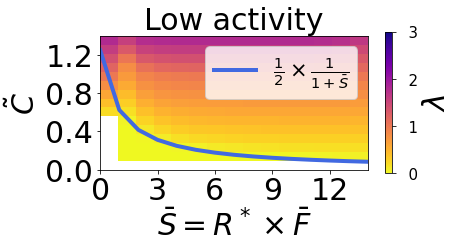

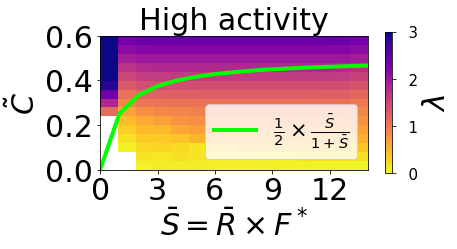

In [60]:
# Plot of the eigenvalues and the function C_R and C_P
# map_P = np.reshape(save_eigenvalues_P,(len(S_values),len(C_values)))
# map_R = np.reshape(save_eigenvalues_R,(len(S_values),len(C_values)))
eigenvalues_R_nan = eigenvalues_R.copy()
eigenvalues_P_nan = eigenvalues_P.copy()
num_err = 10e-8
eigenvalues_R_nan[eigenvalues_R_nan < num_err] = np.nan
eigenvalues_P_nan[eigenvalues_P_nan < num_err] = np.nan
min_eigen_R = np.min(eigenvalues_R[eigenvalues_R > num_err])
max_eigen_R = np.max(eigenvalues_R[eigenvalues_R > num_err])
min_eigen_P = np.min(eigenvalues_P[eigenvalues_P > num_err])
max_eigen_P = np.max(eigenvalues_P[eigenvalues_P > num_err])

cmap=plt.get_cmap('plasma_r')
S_array = S_values * ds
xmin = S_array[0]
xmax = S_array[-1]
ymin = C_values[0]
ymax = C_values[-1]

# Expronent
a = 2.5

labelsize = 30
fig = plt.figure()
ax = fig.add_subplot(111)
im = plt.imshow(eigenvalues_R_nan,extent=[xmin,xmax,ymax,ymin],cmap=cmap, aspect=10, vmin=0, vmax=3)
ax.plot(S_array,C_R(S_array,a),color='royalblue',linewidth=4,label=r'$\frac{1}{2}\times\frac{1}{1+\bar{S}}$')
ax.tick_params(labelsize=labelsize)
ax.set_title("Low activity",fontsize=labelsize)
ax.set_xlabel(r'$\bar{S}=R^*\times \bar{F}$', fontsize = labelsize)
ax.set_ylabel('$\~C$', fontsize = labelsize)
plt.xticks(np.arange(0, 15, step=3), fontsize=labelsize)
plt.yticks(np.arange(0, 1.4, step=0.4), fontsize=labelsize)
forceAspect(ax,aspect=2)
v1 = np.linspace(0, 3, 4, endpoint=True)
cb = plt.colorbar(ticks=v1, shrink=0.65)
cb.ax.set_yticklabels(["{:3.0f}".format(i) for i in v1], fontsize='15')
plt.gca().invert_yaxis()
cb.set_label("$\lambda$",fontsize=labelsize)
plt.legend(fontsize=labelsize*0.7)
fig.savefig('image/linearisation_map_R_a='+str(a)+'_poster.png', bbox_inches="tight", dpi=200)

fig = plt.figure()
ax = fig.add_subplot(111)
im = plt.imshow(eigenvalues_P_nan,extent=[xmin,xmax,0.6,ymin],cmap=cmap, aspect=10, vmin=0, vmax=3)
ax.plot(S_array,C_P(S_array),color='lime',linewidth=4,label=r'$\frac{1}{2}\times\frac{\bar{S}}{1+\bar{S}}$')
ax.tick_params(labelsize=labelsize)
ax.set_title("High activity",fontsize=labelsize)
ax.set_xlabel(r'$\bar{S}=\bar{R}\times F^*$', fontsize = labelsize)
ax.set_ylabel(r'$\~C$', fontsize = labelsize)
plt.xticks(np.arange(0, 15, step=3), fontsize=labelsize)
plt.yticks(np.arange(0, 0.7, step=0.2), fontsize=labelsize)
forceAspect(ax,aspect=2)
v1 = np.linspace(0, 3, 4, endpoint=True)
cb = plt.colorbar(ticks=v1, shrink=0.65)
cb.ax.set_yticklabels(["{:3.0f}".format(i) for i in v1], fontsize='15')
plt.gca().invert_yaxis()
cb.set_label("$\lambda$",fontsize=labelsize)
plt.legend(fontsize=labelsize*0.7)
fig.savefig('image/linearisation_map_P_2_poster.png', bbox_inches="tight", dpi=200)

In [13]:
eigenvalues_P_nan

array([[       nan,        nan, 0.06537647, 0.09076711, 0.09196065,
        0.08596812, 0.07884385, 0.07211646, 0.06612802, 0.06085033,
        0.0560738 , 0.05134146, 0.04558553, 0.03590534, 0.01182153],
       [       nan,        nan, 0.15080146, 0.12101304, 0.16692572,
        0.1379177 , 0.07782052, 0.07357874, 0.06972048, 0.08517126,
        0.12604413, 0.16945255, 0.18819207, 0.19129098, 0.16545546],
       [       nan, 0.05066167, 0.21499477, 0.25239663, 0.22514526,
        0.14996403, 0.30816614, 0.35944901, 0.38502423, 0.39923866,
        0.40747753, 0.41196013, 0.41269768, 0.4052078 , 0.36761288],
       [       nan, 0.16185091, 0.30493652, 0.33254887, 0.38278829,
        0.48847561, 0.5304118 , 0.55019596, 0.56028054, 0.56563193,
        0.56846758, 0.56965021, 0.56861035, 0.56048462, 0.52023329],
       [       nan, 0.30037781, 0.43725444, 0.45088083, 0.60437866,
        0.66064249, 0.68384232, 0.69433263, 0.69930916, 0.70172437,
        0.70286216, 0.7031469 , 0.70191257, 